In [1]:
from __future__ import print_function, division, absolute_import
import os
import sys
sys.path.insert(0, "C:\\Users\\Matt\\Desktop\\orbithunter\\")
from orbithunter import *
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
from orbithunter.discretization import correct_aspect_ratios

In [3]:
from orbithunter.gluing import tile_dictionary_ks
import itertools

In [4]:
def correct_aspect_ratios(iterable_of_orbits, gluing_axis=0):
    iterable_of_dims = [o.dimensions[gluing_axis] for o in iterable_of_orbits.ravel()]
    iterable_of_shapes = [o.field_shape[gluing_axis] for o in iterable_of_orbits.ravel()]
    disc_total = np.sum(iterable_of_shapes)
    dim_total = np.sum(iterable_of_dims)
    fraction_array = np.array(iterable_of_dims) / dim_total 
    new_discarray = 2 * np.round((fraction_array * disc_total) / 2)
    number_of_dimensionless =  np.sum(fraction_array==0)
    number_of_dimensionful = len(new_discarray)-number_of_dimensionless

    new_discarray = new_discarray.astype(int)
    while np.sum(new_discarray) != disc_total:
        new_discarray[np.mod(np.sum(new_discarray), 2) == 1] += 1
        if np.sum(new_discarray) < disc_total:
            new_discarray[np.argmax(new_discarray)] += 2
        else:
            new_discarray[np.argmax(new_discarray)] -= 2
    fraction_array = np.array(new_discarray) / np.sum(new_discarray) 

        # Can't have orbits with 0 discretization but don't want them too large because they have no inherent scale. 
    if number_of_dimensionless == len(iterable_of_shapes):
        # if gluing all equilibria in time, don't change anything. 
        new_shapes = [o.shape for o in iterable_of_orbits.ravel()]

    elif number_of_dimensionless > 0 and number_of_dimensionful >= 1:
        # safety net, do not make any larger than original size. 
        half_dimless_disc = np.min([np.max([2 * (iterable_of_shapes[0] // (2*number_of_dimensionless*number_of_dimensionful)),
                                    disc_total // (len(iterable_of_shapes)*number_of_dimensionless),
                                   2*int(((np.round(1.0 / np.min(fraction_array[fraction_array!=0]))+1))//2)]),
                                    iterable_of_shapes[0]//2])
        # Take half of the minimum dimension and find the proportion we would take from each other orbit.
        # multiply by two to get an even total.
        how_much_to_take_away_for_each = 2 * np.round(half_dimless_disc * fraction_array)
        # Once we know how much to take for each dimensionless, subtract it. Note that multiplying by 2 makes each entry even,
        # and also makes the sum even. 

        new_discarray = new_discarray - number_of_dimensionless * how_much_to_take_away_for_each
        new_discarray[new_discarray == 0] = np.sum(how_much_to_take_away_for_each)
        new_discarray = new_discarray.astype(int)
        new_shapes = [tuple(int(new_discarray[j]) if i == gluing_axis else o.field_shape[i] 
                        for i in range(len(o.shape))) for j, o in enumerate(iterable_of_orbits.ravel())]
    else:
        new_shapes = [tuple(int(new_discarray[j]) if i == gluing_axis else o.field_shape[i] 
                      for i in range(len(o.shape))) for j, o in enumerate(iterable_of_orbits.ravel())]
    # Replace the # of points along axis with the rescaled values based upon the total extent of the axis dimension.
    # Finds the correct discretization sizes given the proportions of each orbit along the specified axis

    return [rediscretize(o, new_shape=shp) for o, shp in zip(iterable_of_orbits.ravel(), new_shapes)]

In [5]:
np.random.seed(42)
symbol_array = (3*np.random.rand(2,4)).astype(int)
gluing_shape = symbol_array.shape

I think correcting aspect ratio will work as long as they start with the same discretization size in every dimension.

In [6]:
td =  tile_dictionary_ks()
orbit_array = np.array([rediscretize(td[symbol], new_shape=(32,32)).convert(to='field') 
                        for symbol in symbol_array.ravel()]).reshape(*symbol_array.shape)

In [7]:
# np.reshape([x.N for x in orbit_array_corrected.ravel()], symbol_array.shape).sum(axis=0)

In [8]:
3. not in [0, 0.] 

True

In [9]:
gluing_axis=1

In [10]:
n_dims = len(orbit_array.shape)

In [11]:
orbit_array_4d = np.tile(np.array(orbit_array).reshape(2, 4, 1, 1), (1, 1, 3, 5))

In [12]:
glue_shape = orbit_array.shape
non_gluing_dimensions = tuple(array_dimension for i, array_dimension in enumerate(orbit_array.shape) if i != gluing_axis)
gluing_slices = list(itertools.product(*(range(g) if i != gluing_axis else [slice(None)] for i, g in enumerate(glue_shape))))

Array gluing w/ no fixing.

    1. requires fields to all have same discretization size. 
    2. simply take fields and concatenate, iterating through symbol array axes, figuring out which axis to concat for each.
    

Stripwise gluing.

    1. determine order of gluing axes.
    2. Take the strips along the first axis.
    3. Iterate through strips:
        a. correct aspect ratios of fields
        b. glue parameters stripwise
        c. create new orbit instance for the glued arrays, parameters.
        d. add new orbit instances to list
        e. replace the dimension in gluing array corresponding to axis with 1. 
        f. reshape the list w.r.t remaning symbol array dimensions?
        g. repeat until gluing axes are all equal to 1. 
        
Things to consider. when len(glue_shape) < len(symbol_array_shape) how does concatenation work. 
Is it easiest to swapaxes back and forth? or figure out the axes  to glue w.r.t. 
    
Things that need to be taken care of. If not caring about aspect ratios, just glue all parameters, glue all orbits by axis. 

If gluing strips, want to glue in order of smallest to largest array axes?

In [13]:
test = np.ones([8, 8, 8, 8, 3])
glue_shape = (4, 3, 5)

What this indicates is that the final shape of the field should be ```glued_state_shape == (16, 32, 24, 40, 3)```
first, tile the "state"

In [14]:
test_gluing_state = np.tile(test, (4,3,5, 1, 1, 1, 1, 1))
test_gluing_state.shape

(4, 3, 5, 8, 8, 8, 8, 3)

In [15]:
step1 = np.concatenate(test_gluing_state, axis=3)

The way that concat works, it always treats the array as an iterable of arrays, i.e. (n, remaining_shape). So
telling it to concat along axis=1 combines axis=0 and axis=1 OF THE FINAL SHAPE. That means that if we want to combine 2 and 5 into an array of shape ```(4,3,10,8,8,8,8,3)```, we would specify axis=2. This means that to concatenate how we want, we can repeat the concatenation along the same axis, once for each gluing coordinate. The value is equal to len(gluing_shape) - 1. If given a glue shape of dimension less than the state's dimension, then this type of concatenation will always result the first coordinates being glued. Can either fill the missing dimensions with 1's, i.e. (2, 4, 3, 5) -> (1, 4, 3, 5) or simply make the axis equal to the number of dimensions, independent of the glue shape. i.e. n_dim - 1? I don't like this because this means that if I pass the shape (2,2) it will assume this means (y, z) if dimensions are (t, x, y, z). This doesn't seem intuitive.

But this also means that the gluing shape will have to remain D dimensional to work, skipping over values of 1. I think it only makes sense to require the shape to always be D dimensional. In K-S if I just say 2 it does not contain enough info to glue. Only by specifying (2, 1) or (1, 2) does this make sense.

In [16]:
n_dim = 4

In [17]:
while len(test_gluing_state.shape) > 5:
    test_gluing_state = np.concatenate(test_gluing_state, axis=(n_dim-1))

In [18]:
test_gluing_state.shape

(8, 32, 24, 40, 3)

This works generically, for now let's assume there is no preferred order 

In [19]:
np.random.seed(42)
symbol_array = (3*np.random.rand(13,11)).astype(int)
gluing_shape = symbol_array.shape

In [20]:
gluing_shape

(13, 11)

In [27]:
# for gs in gluing_slices:
#     zipped_dimensions = tuple(zip(*(o.dimensions for o in orbit_array[gs].ravel())))
#     strip_shape = tuple(len(orbit_array[gs]) if n == gluing_axis else 1 for n in range(len(orbit_array.shape)))
#     glued_parameters = OrbitKS.glue_parameters(zipped_dimensions, glue_shape=strip_shape)
#     orbit_array_corrected =  correct_aspect_ratios(orbit_array, gluing_axis=0)
glue_shape = symbol_array.shape
gluing_order = np.argsort(glue_shape)
gluing_order = (1, 0)
td =  tile_dictionary_ks()
orbit_array = np.array([rediscretize(td[symbol], new_shape=(16,16)).convert(to='field') 
                        for symbol in symbol_array.ravel()]).reshape(*symbol_array.shape)

for gluing_axis in gluing_order:
    gluing_slices = list(itertools.product(*(range(g) if i != gluing_axis else [slice(None)] 
                                             for i, g in enumerate(glue_shape))))
    glued_orbit_strips = []
    for gs in gluing_slices:
        zipped_dimensions = tuple(zip(*(o.dimensions for o in orbit_array[gs].ravel())))
        
        strip_shape = tuple(len(orbit_array[gs]) if n == gluing_axis else 1 for n in range(len(orbit_array.shape)))
        glued_parameters = OrbitKS.glue_parameters(zipped_dimensions, glue_shape=strip_shape)
        strip_of_orbits = orbit_array[gs].reshape(strip_shape)
        orbit_array_corrected =  correct_aspect_ratios(strip_of_orbits, gluing_axis=gluing_axis)
        glued_strip_state = np.concatenate(tuple(x.state for x in orbit_array_corrected), axis=gluing_axis)
        glued_strip_orbit = OrbitKS(state=glued_strip_state, state_type='field', orbit_parameters=glued_parameters)
        glued_orbit_strips.append(glued_strip_orbit)
    glue_shape = tuple(glue_shape[i] if i != gluing_axis else 1 for i in range(len(glue_shape)))
    orbit_array = np.array(glued_orbit_strips).reshape(glue_shape)
    if orbit_array.size == 1:
        glued_orbit = orbit_array.ravel()[0]

In [28]:
glued_orbit

OrbitKS({"state_type": "field", "T": "2.15e+02", "L": "1.30e+02", "N": "208", "M": "176"})

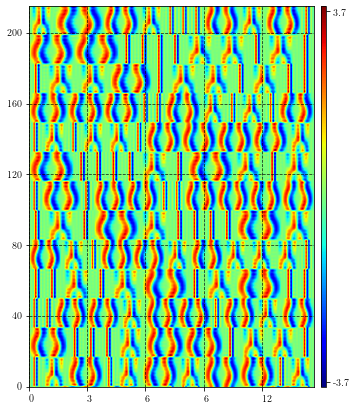

In [29]:
glued_orbit.plot()

In [30]:
orbit0 = read_h5('OrbitKS_L31p245_T46p754.h5')
orbit1 = read_h5('OrbitKS_L26p931_T41p266.h5')
orbit2 = read_h5('OrbitKS_L38p516_T65p638.h5')
orbit3 = read_h5('OrbitKS_L27p038_T23p329.h5')
orbit4 = read_h5('OrbitKS_L35p379_T31p619.h5')

td = {0 : orbit0, 1: orbit1, 2: orbit2, 3:orbit3, 4:orbit4}

In [31]:
tmp = class_convert(orbit0, RelativeOrbitKS)

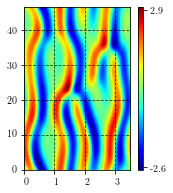

In [32]:
tmp.plot(fundamental_domain=False)

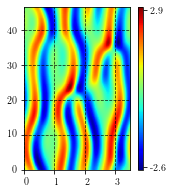

In [33]:
tmp.plot()

In [34]:
np.random.seed(42)
symbol_array = (5 * np.random.rand(13,11)).astype(int)
gluing_shape = symbol_array.shape

orbit_array = np.array([rediscretize(td[symbol], new_shape=(32,32)).convert(to='field') 
                        for symbol in symbol_array.ravel()]).reshape(*symbol_array.shape)

In [35]:
tuple(32*d for d in orbit_array.shape)

(416, 352)

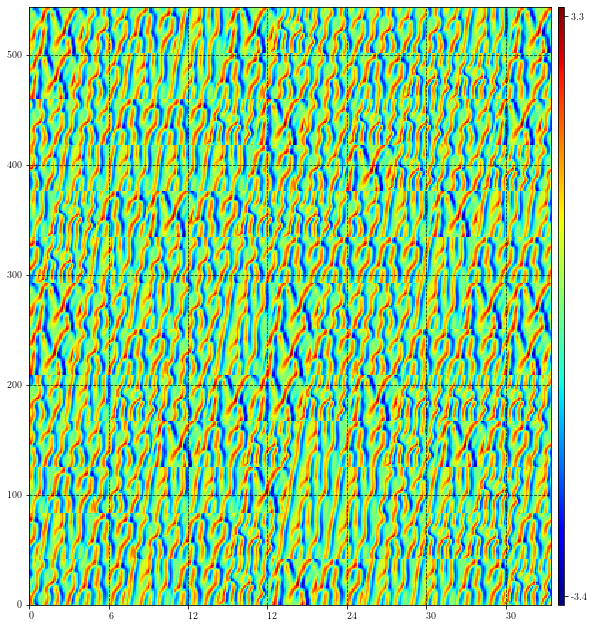

In [36]:
glue_shape = symbol_array.shape
gluing_order = np.argsort(glue_shape)
gluing_order = (1, 0)
tiling_shape = orbit_array.ravel()[0].shape

gluing_axis = len(glue_shape) - 1
zipped_dimensions = tuple(zip(*(o.dimensions for o in orbit_array.ravel())))
glued_parameters = OrbitKS.glue_parameters(zipped_dimensions, glue_shape=glue_shape)
orbit_field_list = [o.convert(to='field').state for o in orbit_array.ravel()]
glued_orbit_state = np.array(orbit_field_list).reshape(*orbit_array.shape, *tiling_shape)

while len(glued_orbit_state.shape) > len(tiling_shape):
    glued_orbit_state = np.concatenate(glued_orbit_state, axis=gluing_axis)


arraywise_glued_orbit = RelativeOrbitKS(state=glued_orbit_state, state_type='field', orbit_parameters=glued_parameters)

arraywise_glued_orbit.plot()

In [31]:
arraywise_glued_orbit.residual()

199789.77647429515

In [35]:
big_tiling_converge_result = converge(arraywise_glued_orbit, method='gradient_descent', verbose=True, precision='very_high', orbit_maxiter=10000)

Starting gradient descent. Initial residual=199789.77647429515, target=0.000146432, max_iter=10000
######### Residual=2263.149038486281 after 1000 gradient descent iterations
######### Residual=1504.8752334217422 after 2000 gradient descent iterations
######### Residual=1258.6503450878397 after 3000 gradient descent iterations
######### Residual=1159.7132029613406 after 4000 gradient descent iterations
######### Residual=1094.1750536429893 after 5000 gradient descent iterations
######### Residual=945.83875604408 after 6000 gradient descent iterations
######### Residual=840.5139950031235 after 7000 gradient descent iterations
######### Residual=720.9544273887218 after 8000 gradient descent iterations
######### Residual=663.8103852457446 after 9000 gradient descent iterations
######### Residual=618.079600757173 after 10000 gradient descent iterations

Failed to converge. Maximum number of iterations reached. exiting with residual 618.079600757173


In [36]:
big_tiling_converge_result.orbit.residual()

618.079600757173

In [37]:
big_tiling_converge_result.plot()

NameError: name 'big_tiling_converge_result' is not defined

In [85]:
glue_shape = symbol_array.shape
gluing_order = np.argsort(glue_shape)
gluing_order = (1, 0)
state_shape = len(OrbitKS.dimension_labels())
td =  tile_dictionary_ks()
orbit_array = np.array([rediscretize(td[symbol], new_shape=(32,32)).convert(to='field') 
                        for symbol in symbol_array.ravel()]).reshape(*symbol_array.shape)
tiling_shape = orbit_array.ravel()[0].shape

gluing_axis = len(glue_shape) - 1
zipped_dimensions = tuple(zip(*(o.dimensions for o in orbit_array.ravel())))
glued_parameters = OrbitKS.glue_parameters(zipped_dimensions, glue_shape=glue_shape)
orbit_field_list = [o.convert(to='field').state for o in orbit_array.ravel()]
glued_orbit_state = np.array(orbit_field_list).reshape(*orbit_array.shape, *tiling_shape)

while len(glued_orbit_state.shape) > len(tiling_shape):
    glued_orbit_state = np.concatenate(glued_orbit_state, axis=gluing_axis)


arraywise_glued_orbit = RelativeOrbitKS(state=glued_orbit_state, state_type='field', orbit_parameters=glued_parameters)

arraywise_glued_orbit.plot()

KeyError: 4

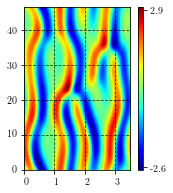

In [77]:
orbit0.plot()

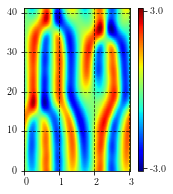

In [78]:
orbit1.plot()

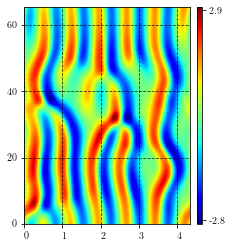

In [79]:
orbit2.plot()

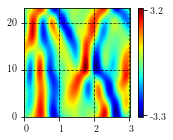

In [80]:
orbit3.plot()

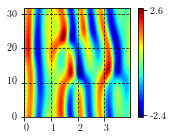

In [81]:
orbit4.plot()

# "stripwise" gluing.

Does order matter? Yes.

For every axis in orbit_array shape/gluing_shape/symbol_shape. 
Iterate through other axes to get "strips" along the gluing axis.
For each of those strips, run it through the aspect ratio correction process.

Iterate through non-gluing axis indices, these are strips, then iterate through strips in the correct aspect ratio process.
Once the strips have been corrected, concatenate them along the gluing axis thens start over by iterating through the remaining axes

Has issues when remainder is 0.5 before rounding. 